In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from patsy import dmatrices

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
%matplotlib inline

# Source of plots: https://tjo-en.hatenablog.com/entry/2014/01/06/234155

In [3]:
def show_image(url, size = (8,8)):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.figure(figsize = size)
    plt.axis('off')
    _ = plt.imshow(img, interpolation='lanczos')

# 1. No free lunch theorem #

>"Classifier performance depends greatly on the characteristics of the data to be classified. There is no single classifier that works best on all given problems (a phenomenon that may be explained by the no-free-lunch theorem). Various empirical tests have been performed to compare classifier performance and to find the characteristics of data that determine classifier performance. **Determining a suitable classifier for a given problem is however still more an art than a science.**"

Wikipedia: https://en.wikipedia.org/wiki/Statistical_classification#Evaluation

In [9]:
#show_image('http://ki.pwr.edu.pl/lemiesz/info/4.png')

# 2. Decision Tree Classifier #


In [8]:
#show_image('http://ki.pwr.edu.pl/lemiesz/info/5.png')

In [ ]:
?DecisionTreeClassifier

In [18]:
# Split the data into 
df = pd.read_csv("Auto.csv")
mask = np.random.rand(len(df)) < 0.8
train = df[mask]
valid = df[~mask]
        
# Prepare the data 
model_formula = 'origin ~ weight + displacement + cylinders '
y_train, X_train = dmatrices(model_formula, data=train, return_type='dataframe')   
y_valid, X_valid = dmatrices(model_formula, data=valid, return_type='dataframe')

# Define a model
model = DecisionTreeClassifier(criterion="entropy")
result = model.fit(X_train, y_train)

# accuracy of our prediction on validation set
print("Training accuracy: ", accuracy_score(y_true=y_train, y_pred=model.predict(X_train)))

# # Log_loss on validation set -> we use  model.predict_proba() 
print("Training log-loss", log_loss(y_train, model.predict_proba(X_train)))

# accuracy of our prediction on validation set
print("Validation accuracy: ", accuracy_score(y_true=y_valid, y_pred=model.predict(X_valid)))

# Confusion_matrix
print("Confusion_matrix: \n", confusion_matrix(y_true=y_valid, y_pred=model.predict(X_valid)))



Training accuracy:  0.9968253968253968
Training log-loss 0.006062039698047936
Validation accuracy:  0.8536585365853658
Confusion_matrix: 
 [[48  0  0]
 [ 2  8  5]
 [ 3  2 14]]


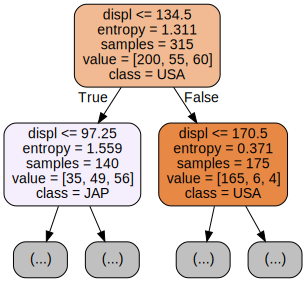

In [19]:
# Plottin the tree - need to install graphviz 
# see e.g. https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

import graphviz 
dot_data = export_graphviz(result, max_depth=1, out_file=None, filled=True, rounded=True,  class_names=['USA','EU','JAP'], feature_names=['int','weight','displ', 'cylin'])
graph = graphviz.Source(dot_data) 
graph

# 3. k-Fold cross-validation #

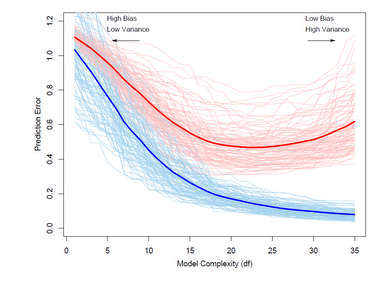

In [13]:
show_image('http://ki.pwr.edu.pl/lemiesz/info/testMSE.png', size = (6,6))


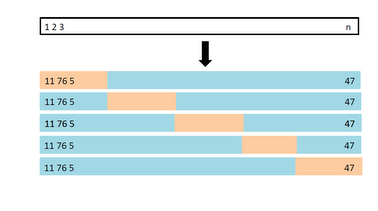

In [14]:
show_image('http://ki.pwr.edu.pl/lemiesz/info/kfold.png', size=(6,6))

### Create a model ###

In [15]:
model_formula = 'origin ~  weight + displacement + cylinders'
y, x = dmatrices(model_formula, data=df, return_type='dataframe') 
Y = y.values.ravel()
X = x.values

# # Use below function to generate artifical dataset for classification
# X, Y = make_classification(n_classes=10, n_samples=100, n_features=100,
#                             n_informative=5, n_redundant=95,
#                            random_state=0, shuffle=True)

### Cross-validation code ###

LRE :     mean: 0.722115       std: 0.105393
KNN1:     mean: 0.714808       std: 0.107216
KNN5:     mean: 0.717500       std: 0.096187
DTC1:     mean: 0.818269       std: 0.054159
DTC2:     mean: 0.848397       std: 0.049579
DTC3:     mean: 0.740513       std: 0.081791


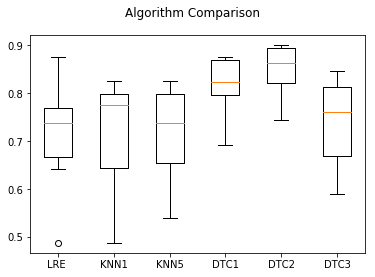

In [16]:
# code based on the https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# set seed for cross validation
seed = 1
# prepare models
models = []
models.append(('LRE ', LogisticRegression()))
models.append(('KNN1', KNeighborsClassifier(n_neighbors=1)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5)))
models.append(('DTC1', DecisionTreeClassifier(criterion='gini')))
models.append(('DTC2', DecisionTreeClassifier(criterion='entropy')))
models.append(('DTC3', DecisionTreeClassifier(max_depth=3)))
DecisionTreeClassifier
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s:     mean: %f       std: %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# 5. Grid search based on cross validation #

In [19]:
from sklearn.model_selection import GridSearchCV

params_opt = {'max_depth':range(1, 30, 1), 'max_leaf_nodes':range(5,50,5)}

gridSearchCV = GridSearchCV(
    estimator = DecisionTreeClassifier(), 
    param_grid = params_opt, 
    cv=5)
gridSearchCV.fit(X,Y)

# print(gridSearchCV.grid_scores_) 

print('Best parameters: %s' % gridSearchCV.best_params_) 
print('Best mean accuracy: %s' %gridSearchCV.best_score_)


Best parameters: {'max_depth': 7, 'max_leaf_nodes': 35}
Best mean accuracy: 0.8060453400503779


# 5. Random Forest #

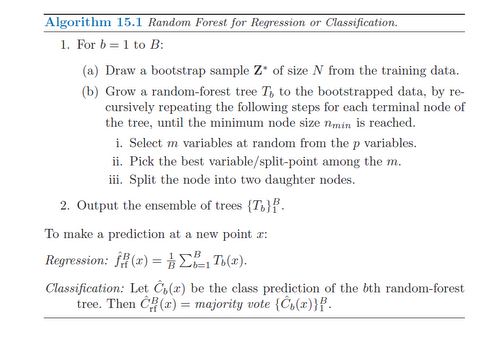

In [22]:
show_image('http://ki.pwr.edu.pl/lemiesz/info/alg.png')
# source: Elements of Statistical Learning by Hastie Trevor et al.

## Random forest with grid search ##

In [13]:
model_formula = 'origin ~  weight + displacement + cylinders'

y, x = dmatrices(model_formula, data=df, return_type='dataframe') 
Y = y.values.ravel()
X = x.values

params_opt = {
    'n_estimators':range(10,50,10),
    'max_depth':range(5,20,5), 
    'criterion':['gini', 'entropy']}

gridSearchCV = GridSearchCV(
    estimator = RandomForestClassifier(), 
    param_grid = params_opt, 
    cv=10)
gridSearchCV.fit(X,Y)

# print(gridSearchCV.grid_scores_) 

print('Best parameters: %s' % gridSearchCV.best_params_) 
print('Best mean accuracy: %s' %gridSearchCV.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 30}
Best mean accuracy: 0.836272040302267


## Random Forest with OOB (Out-of-the-Bag) error ##

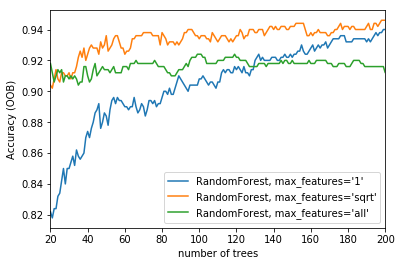

In [45]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

#Generate artifical data for classification problem
X, y = make_classification(n_samples=500,
                           n_features=25,
                           n_clusters_per_class=1,
                           n_informative=15,
                           random_state=123)

# We will check random forests with diffretn number 
# of features selected to choose from at each split
RFs = [
    ("RandomForest, max_features='1'",
        RandomForestClassifier(warm_start=True, 
                               max_features=1,
                               oob_score=True,
                               random_state=123)),
    ("RandomForest, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, 
                               oob_score=True,
                               max_features='sqrt',
                               random_state=1)),
    ("RandomForest, max_features='all'",
        RandomForestClassifier(warm_start=True,
                               max_features=None,
                               oob_score=True,
                               random_state=123))

]

# Map a classifier name to a list of (<n_estimators>, <accuracy>) pairs.
accuracy = OrderedDict((label, []) for label, _ in RFs)

# Range of `n_estimators` values to explore.
min_estimators = 20
max_estimators = 200

for label, clf in RFs:
    for i in range(min_estimators, max_estimators + 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_accuracy =  clf.oob_score_
        accuracy[label].append((i, oob_accuracy))

# Generate the "OOB accuracy" vs. "n_trees" plot.
plt.figure(figsize=(6,4)) 
for label, clf_acc in accuracy.items():
    xs, ys = zip(*clf_acc)
    plt.plot(xs, ys, label=label)


plt.xlim(min_estimators, max_estimators)
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (OOB)")
plt.legend(loc="lower right")
plt.show()

<b>Trade-off:</b> how good is a single tree vs. how indepentent are results from  diffretn trees